In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2
%autosave 180

import sys
sys.path.append("../input/dataset")

Autosaving every 180 seconds


# Convolutional Neural Networks

**Objective:** This assignment aims to help you understand CNNs through implementing layers for a CNN network. It also provide you a chance to tune a CNN. 


**Tasks:** The first part of the assignment asks you to implement three types of layers (batch normalization, convolution, and pooling) that are commonly used in CNNs. To reduce the level of difficulty, you can implement convolution and pooling layers with `numpy`, and you are allowed to use for-loops. Your calculation will be compared against `torch` functions. 

The second part of the assignment asks you to construct and train a convolutional neural network on the **bean-leaf dataset ([link](https://www.kaggle.com/datasets/prakharrastogi534/bean-leaf-dataset))**. In this part work, you need to code up your own convolutional neural network using `torch` layers. Then you apply the CNN to the dataset. You need to tune the model and try to get the highest test accuracy. 


**Detailed Instructions:**  Please implement all functions in `my_layers.py` and run through tests of your layers in this ipython notebook. You also need to construct a CNN in `conv_net.py`. 

Then you need to train the CNN you have implemented. You may want to tune your CNN through multiple runs of training and validation to find a good model. You can consider `pytorch_lightning` to tune hyperparameters. 

At the end, you need to save your model to this folder for submission. We will test your saved model to decide your points for the last part of work. 


**Grading:** Please finish your work in the folder `assignment3`. If you use google colab, please upload folder `assignment3` to your google drive and run your code there. When you have finished your work, please print your notebook to a pdf file and put it to `assignment3`. You need to submit the entire `assignment3` folder, which should contain:  
* all your implementations;
* the notebook that can run with your implementations; 
* your saved model; and
* a pdf print of your notebook. 

(If Gradescope does not accept your submission due to size limit, please let us know).

When we grade your code, we check your result notebook as well as your code. If your code cannot generate the result of a problem in your notebook file, you will get zero point for that problem. 

**GPU resources:** In this assignment you will need to use GPU to tune your model for the bean-leaf task. You can use GPU from google colab and Kaggle. You have up to 30 GPU hours/week from Kaggle ([link](https://www.kaggle.com/general/108481)). Google colab does not have an anounced limit, but you should be able to get more hours than Kaggle. Here are some tips for GPU usage. 

1. Only use GPU when necessary. You may want to garantee that your model runs before you put it to GPU.
2. Start your work early, so you have more GPU time
3. Remember to release GPU when you don't run your model. 

**Deadline:** Oct 25, 23:59pm, 2022. 

In [2]:
# As usual, a bit of setup
import numpy as np
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython


def mean_diff(x, y):
    with torch.no_grad():
        if isinstance(x, torch.Tensor):
            x = x.numpy()
        if isinstance(y, torch.Tensor):
            y = y.numpy()
        err = np.mean(np.abs(x - y))
    return err

# If you have cuda, do the following
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Batch normalization
**Question 1 (4 points).** Please implement the batch normalization layer in `bn_layer.py`. The following code block will test your implementation against the `torch` implementation. Please refer to the documentation of `torch.nn.BatchNorm2d`([link](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)) for the detailed calculation of batch normalization. 

In [3]:
from bn_layer import BNLayer
from torch.nn import BatchNorm2d
# initialize a tensor X and pretend that the tensor is a feature map in a CNN. 
# In this case, we do normalization over different channels. As we have mentioned in the 
# class, all pixels in a channel share the same normalization parameters. 

np.random.seed(137)
N, C, H, W = 200, 5, 50, 60
X = torch.tensor(np.random.randn(N, C, H, W) * 0.2 + 5, dtype = torch.float32)

# initialize parameters for batch normalization

momentum = 0.1
epsilon = 0.01


# batch_normalization with torch. 

torch_bn = BatchNorm2d(5, eps = epsilon, momentum = momentum, dtype = torch.float32)

# we use the same parameters as torch batch normalization.
my_bn = BNLayer(5, eps=epsilon, momentum=momentum)


# compare computation results over different training batches. 

res_tf = torch_bn(X[0:10])
res_my = my_bn(X[0:10])


print("Calculation from the first batch: the difference between the two implementations is ",
          mean_diff(res_tf, res_my))

# run batch normalization on the second batch

res_tf = torch_bn(X[10:20])
res_my = my_bn(X[10:20])

print("Calculation from the second batch: the difference between the two implementations is ",
          mean_diff(res_tf, res_my))

# run batch normalization on the third batch

res_tf = torch_bn(X[20:30])
res_my = my_bn(X[20:30])

print("Calculation from the third batch: the difference between the two implementations is ",
          mean_diff(res_tf, res_my))

# compare computation results over a testing batch
my_bn.eval()
torch_bn.eval()

res_tf = torch_bn(X[40:50])
res_my = my_bn(X[40:50])
print("Calculation from testing: the difference between the two implementations is ",
       mean_diff(res_tf, res_my))


Calculation from the first batch: the difference between the two implementations is  9.027351e-07
Calculation from the second batch: the difference between the two implementations is  1.3271853e-06
Calculation from the third batch: the difference between the two implementations is  1.4718751e-06
Calculation from testing: the difference between the two implementations is  1.1666425e-06


## The convolution operation

**Question 2 (4 points).** Please implement a convolutional operation in `my_layers.py`. The following code block will test your implementation against the corresponding `torch` function. Please refer to the documentation of `torch.nn.Conv2d` for the detailed calculation of the convolution operation. 

**Note:** You only need to consider `stride = 1`, `padding` is `same` or `valid`. 

In [3]:
from my_layers import conv_forward
import torch.nn as nn

# initialize a tensor in the NCHW format and pretend the tensor is a feature map in a CNN. 
x = np.random.randn(*[1, 5, 10, 20]).astype(np.float32)


# The first test case: 
h_stride = 1
w_stride = 1
padding = "same"
t_mod = nn.Conv2d(in_channels=5, out_channels = 4, kernel_size = (3,3), stride=[h_stride, w_stride], padding=padding)
t_out = t_mod(torch.tensor(x, dtype = torch.float32))
with torch.no_grad():
    w = t_mod.weight.numpy()
    b = t_mod.bias.numpy()
out = conv_forward(input=x, filters=w, bias = b, stride=[h_stride, w_stride], padding=padding)

with torch.no_grad():
    print('Difference between your implementation and torch calculation:', mean_diff(out, t_out))

# The second test case: 
h_stride = 1
w_stride = 1
padding = "same"
t_mod = nn.Conv2d(in_channels=5, out_channels = 4, kernel_size = (7,7), stride=[h_stride, w_stride], padding=padding)
t_out = t_mod(torch.tensor(x, dtype = torch.float32))
with torch.no_grad():
    w = t_mod.weight.numpy()
    b = t_mod.bias.numpy()
out = conv_forward(input=x, filters=w, bias = b, stride=[h_stride, w_stride], padding=padding)

with torch.no_grad():
    print('Difference between your implementation and torch calculation:', mean_diff(out, t_out))


# The third test case: 
h_stride = 1
w_stride = 1
padding = "valid"
t_mod = nn.Conv2d(in_channels=5, out_channels = 4, kernel_size = (7,3), stride=[h_stride, w_stride], padding=padding)
t_out = t_mod(torch.tensor(x, dtype = torch.float32))
with torch.no_grad():
    w = t_mod.weight.numpy()
    b = t_mod.bias.numpy()
out = conv_forward(input=x, filters=w, bias = b, stride=[h_stride, w_stride], padding=padding)

with torch.no_grad():
    print('Difference between your implementation and torch calculation:', mean_diff(out, t_out))


# The third test case: 
w = np.random.randn(3, 3, 5, 4).astype(np.float32)
h_stride = 1
w_stride = 1
padding = "valid"

t_mod = nn.Conv2d(in_channels=5, out_channels = 4, kernel_size = (3, 3), stride=[h_stride, w_stride], padding=padding)
t_out = t_mod(torch.tensor(x, dtype = torch.float32))
with torch.no_grad():
    w = t_mod.weight.numpy()
    b = t_mod.bias.numpy()
out = conv_forward(input=x, filters=w, bias = b, stride=[h_stride, w_stride], padding=padding)

with torch.no_grad():
    print('Difference between your implementation and torch calculation:', mean_diff(out, t_out))

Difference between your implementation and torch calculation: 4.3121322997425814e-08
Difference between your implementation and torch calculation: 8.508645144502009e-08
Difference between your implementation and torch calculation: 8.448195229801867e-08
Difference between your implementation and torch calculation: 5.6503469952278664e-08


# The max-pooling operation

**Question 4 (4 points).** Please implement the forward pass for the max-pooling operation in the function `pooling_forward_naive` in the file `my_layers.py`. Your implementation will be compared against torch implementation. 

In [5]:
from my_layers import max_pool_forward

np.random.seed(137)
# shape is NCHW
x = np.random.randn(2, 4, 10, 20).astype(np.float32)

pool_height = 3
pool_width = 3
stride_h = pool_height
stride_w = pool_width

my_out = max_pool_forward(x, [pool_height, pool_width], stride=[stride_h, stride_w], padding='VALID')
t_mod = nn.MaxPool2d([pool_height, pool_width], stride=[stride_h, stride_w])
t_out = t_mod(torch.tensor(x, dtype = torch.float32))

with torch.no_grad():
    t_out = t_mod(torch.tensor(x, dtype = torch.float32))
    print('The difference between your implementation and torch operation is: ', mean_diff(my_out, t_out))



pool_height = 4
pool_width = 4
stride_h = 2
stride_w = 2
my_out = max_pool_forward(x, [pool_height, pool_width], stride=[stride_h, stride_w], padding='VALID')
t_mod = nn.MaxPool2d([pool_height, pool_width], stride=[stride_h, stride_w])
t_out = t_mod(torch.tensor(x, dtype = torch.float32))

with torch.no_grad():
    t_out = t_mod(torch.tensor(x, dtype = torch.float32))
    print('The difference between your implementation and torch operation is: ', mean_diff(my_out, t_out))


pool_height = 5
pool_width = 4
stride_h = 2
stride_w = 1

my_out = max_pool_forward(x, [pool_height, pool_width], stride=[stride_h, stride_w], padding='VALID')
t_mod = nn.MaxPool2d([pool_height, pool_width], stride=[stride_h, stride_w])
with torch.no_grad():
    t_out = t_mod(torch.tensor(x, dtype = torch.float32))
    print('The difference between your implementation and torch operation is: ', mean_diff(my_out, t_out))



The difference between your implementation and torch operation is:  0.0
The difference between your implementation and torch operation is:  0.0
The difference between your implementation and torch operation is:  0.0


# Implement a CNN with Keras and train it

In this task, you need to build a CNN with `torch` layers and train it on the `beans` dataset. The `beans` dataset is an image classification task. The dataset contains images of bean leafs, and these images falls into three categories. The task is to predict the label of a leaf. 

**Question 5 (5 points).** Implementation: in your implementation of the neural network, you need to construct your CNN using existing `torch` layers. You cannot directly load a CNN such as ResNet from `torch`. You can check the example code provided by [chapter 8](https://d2l.ai/chapter_convolutional-modern/resnet.html) of D2L book.

NOTE: you cannot copy code from any resources.

**Question 6 (6 points).** Model tuning: depending the final performance of your trained model, you will get
* 2 points for the test accuracy being over 0.7
* 2 points for the test accuracy being over 0.8
* 2 points for the test accuracy being over 0.85


## Train the CNN


### Load Data

In [4]:
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip,RandomVerticalFlip, RandomRotation, RandomGrayscale
from torch.utils.data import random_split, DataLoader
import torch
import copy

In [14]:
from bean_dataset import BeanImageDataset

trainset = BeanImageDataset(
    "../input/bean-leaf-dataset/train/train",
    transform = Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(degrees=180),
    RandomVerticalFlip(p=0.8)
    ]))
validset = BeanImageDataset(
    "../input/bean-leaf-dataset/validation/validation",
    transform = Compose([
    RandomHorizontalFlip(p=0.9),
    RandomRotation(degrees=180),
    RandomVerticalFlip(p=0.8)
    ]))

train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
valid_loader = DataLoader(validset, batch_size=4, shuffle=True)

In [36]:
from conv_net import ConvNet
import numpy as np

if device.type == "cuda":
    total_mem = torch.cuda.get_device_properties(0).total_memory
else:
    total_mem = 0 

epochs = 50
learning_rate = 0.001

model = ConvNet()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                            #  , weight_decay = 0.005, momentum = 0.9)

# Recording the loss
train_loss = []
val_loss   = []
val_acc    = []
best_score = 0
best_model = None

# TODO: implement the training procedure. Please remember to zero out previous gradients in each iteration.
loss_func = nn.CrossEntropyLoss()

for i in range(epochs):
    running_train_loss = 0
    running_val_loss = 0
    running_val_acc = 0

    for j, data in enumerate(train_loader):
        x, y = data
        x = x.float()
        ## If GPU is available, move to cuda 
        if device.type == "cuda":
            x = x.to(device)
            y = y.to(device)

        # TODO: Implement parameter updates here
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_func(outputs, y)
        running_train_loss += loss.item()

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # TODO: Record loss values to some variable
        if device.type == "cuda":
            loss = loss.cpu()
    
    train_loss.append(running_train_loss/(j+1))
    
    # validate
    with torch.no_grad():
        # TODO: compute validation loss and validation accuracy
        correct = 0
        total = 0
        for x_val, y_val in valid_loader:
            x_val = x_val.float()
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            outputs = model(x_val)

            v_loss = loss_func(outputs, y_val)
            running_val_loss += v_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += y_val.size(0)
            correct += (predicted == y_val).sum().item()

        
        running_val_acc = 100* correct / total
        val_loss.append(running_val_loss/(j+1))
        val_acc.append(running_val_acc)
    
    # check GPU memory if necessary
    if device.type == "cuda":
        alloc_mem = torch.cuda.memory_allocated(0)
    else: 
        alloc_mem = 0

    if running_val_acc >= best_score:
        best_model = copy.deepcopy(model)
        best_score = running_val_acc
          
    # print out     
    print(f"Epoch [{i+1}]: Training Loss: {running_train_loss} Validation Loss: {running_val_loss} Accuracy: {running_val_acc}" + (
        f" Allocated/Total GPU memory: {alloc_mem}/{total_mem}" if device.type == "cuda" else ""
    ))

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1]: Training Loss: 1758.60249696971 Validation Loss: 139.57865945806043 Accuracy: 60.150375939849624 Allocated/Total GPU memory: 67564032/15843721216
Epoch [2]: Training Loss: 1249.7773093677715 Validation Loss: 163.1390310494462 Accuracy: 59.3984962406015 Allocated/Total GPU memory: 71525888/15843721216
Epoch [3]: Training Loss: 1182.1430734361015 Validation Loss: 131.84566398756579 Accuracy: 63.1578947368421 Allocated/Total GPU memory: 71525888/15843721216
Epoch [4]: Training Loss: 1065.4152555088745 Validation Loss: 99.24005021318635 Accuracy: 60.902255639097746 Allocated/Total GPU memory: 70623232/15843721216
Epoch [5]: Training Loss: 932.6473497645162 Validation Loss: 73.49933729731129 Accuracy: 62.40601503759399 Allocated/Total GPU memory: 70623232/15843721216
Epoch [6]: Training Loss: 736.1104679079392 Validation Loss: 102.75512770633213 Accuracy: 61.65413533834587 Allocated/Total GPU memory: 70623232/15843721216
Epoch [7]: Training Loss: 645.3457452803254 Validation Loss

Plot training losses, validation losses,  training accuracies, and validation accuracies. If these numbers are from the training on a small dataset, you should see clear overfitting. 

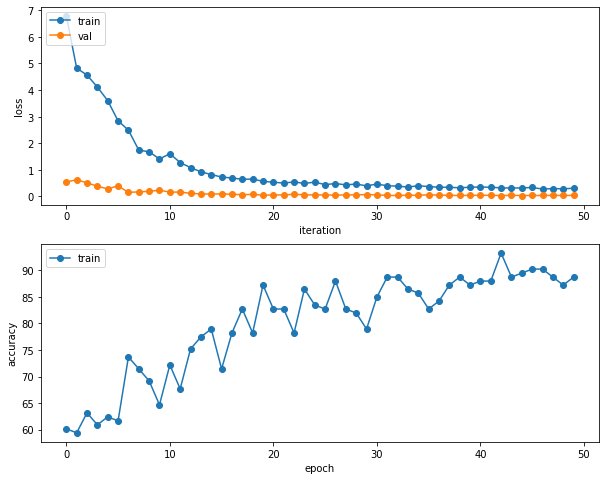

In [40]:
plt.subplot(2, 1, 1)
plt.plot(train_loss, '-o')
plt.plot(val_loss, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(val_acc, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [41]:
torch.save(best_model, "bean_classifier.sav")

## Predict labels of the test set using the saved model

In [42]:
# Load the previously saved model.
testset = BeanImageDataset("../input/bean-leaf-dataset/test/test")
test_loader = DataLoader(testset, batch_size=1, shuffle=True)

saved_model = torch.load("./bean_classifier.sav")
saved_model.eval()


t_acc = []
with torch.no_grad():
    # only one item in the iterator
    # Add more batches if your device couldn't handle the computation 
    for _, data in enumerate(test_loader):
        x, y = data
        x = x.to(device)
        y = y.to(device)
        y_hat = saved_model(x.float())

        if device.type == "cuda":
          x = x.to("cpu")
          y = y.to("cpu")
          y_hat = y_hat.to("cpu")
        acc = np.average(y.numpy() == np.argmax(y_hat.numpy(), axis = 1))
        t_acc.append(acc.item())
print(f"Test accuracy: {np.average(t_acc)}")

Test accuracy: 0.90625
